### Imports and reading data

In [51]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
#Import scaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
#Import pipeline
from sklearn.pipeline import Pipeline

from sklearn.neural_network import MLPRegressor

sns.set(rc={'axes.facecolor': '#2e3b4d', 'figure.facecolor': '#2e3b4d',
        'axes.labelcolor': 'white', 'xtick.color': 'white', 'ytick.color': 'white'})


In [52]:
data = pd.read_csv('train.csv')
data['prcp'].describe()

count    2159.000000
mean        0.056647
std         0.384586
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         7.900000
Name: prcp, dtype: float64

### Data exploration

In [53]:
# Loop through the data indeces
def extend_snow(data):
    data['snow'] = data['snow'].fillna(0)
    snow = 0
    replaceCounter = 0
    for i in range(len(data)):
        # If snowfall is not 0, save the value
        if data['snow'][i] != 0:
            snow = data['snow'][i]
            # Replace the following 24 hours with the saved value
            replaceCounter = 23
        elif (replaceCounter > 0):
            data['snow'][i] = snow
            replaceCounter -= 1
    return data
    
def avg_temp_of_day(data):
    temp = 0
    temp_count = 0
    for i in range(len(data)):
        temp += data['temp'][i]
        temp_count += 1
        if ((i + 1) % 24 == 0):
            for j in range(24):
                data['avg_temp_of_day'][i-j] = temp / temp_count
            temp = 0
            temp_count = 0
    return data

def riigi_pühad(data):

    print(data['date'][0])
    pühad = ['2021-12-24', '2021-12-25', '2021-12-26', '2022-01-01', '2022-02-24', '2022-04-15', '2022-04-17', '2022-05-01', '2022-06-05', '2022-08-20']

    for i in range(len(data)):
        if data['date'][i] in pühad:
            data['riigi_pühad'][i] = 1
        else:
            data['riigi_pühad'][i] = 0

    return data


def kas_Valge(data):
    f = open('uus_paike.txt', 'r')
    line = f.readline()
    for i in range(len(data)):
        line_info = line.split(",")
        line_date = line_info[0]
        # If date is the same
        if data['date'][i] == line_date:
            data_tund = int(data['hour'][i])
            if data_tund >= int(line_info[1]) and data_tund <= int(line_info[2]):
                data['valge'][i] = 1
        else:
            line = f.readline()

    f.close()
    return data

### Data Preprocessing

In [54]:
def preprocess_data(data):

    # Time [time]
    # Splitting time into month, day, hour columns
    data['month'] = data['time'].apply(lambda x: int(x.split('-')[1]))
    data['day'] = data['time'].apply(
        lambda x: int(x.split('-')[2].split(' ')[0]))
    data['hour'] = data['time'].apply(
        lambda x: int(x.split(' ')[1].split(':')[0]))


    # Creating a new column for day of the week (0 = Monday, 6 = Sunday)
    data['date'] = data['time'].apply(lambda x: x.split(' ')[0])

    data['valge'] = 0
    data = kas_Valge(data)


    data['day_of_week'] = pd.to_datetime(data['date']).dt.dayofweek
    # Turning day of the week into a cyclic feature
    data['day_of_week_sin'] = np.sin(data['day_of_week'] * (2 * np.pi / 7))
    data['day_of_week_cos'] = np.cos(data['day_of_week'] * (2 * np.pi / 7))
    # Creating weekend column
    data['weekend'] = data['day_of_week'].apply(lambda x: 1 if x > 4 else 0)

    data = data.drop(['day_of_week'], axis=1)


    # Transform day of the month into a cyclic feature
    data['day_sin'] = np.sin(2 * np.pi * data['day']/31)
    data['day_cos'] = np.cos(2 * np.pi * data['day']/31)
    data = data.drop(['day'], axis=1)

    # Create feature for riigi pühad
    #data['riigi_pühad'] = 0
    #data = riigi_pühad(data)

    # Dropping and date column
    data = data.drop(['date'], axis=1)
    

    # Turning hour into a cyclic feature
    data['hour_sin'] = data['hour'].apply(
        lambda x: np.sin(x * (2 * np.pi / 24)))
    data['hour_cos'] = data['hour'].apply(
        lambda x: np.cos(x * (2 * np.pi / 24)))
    data = data.drop(['hour'], axis=1)


    # Tranforming month column
    data['month_sin'] = data['month'].apply(
        lambda x: np.sin(x * (2 * np.pi / 12)))
    data['month_cos'] = data['month'].apply(
        lambda x: np.cos(x * (2 * np.pi / 12)))
    data = data.drop(['month'], axis=1)

    data = data.drop(['time'], axis=1)
    # Temp [temp]

    # Dew Point [dwpt]

    # Humidity [rhum]

    # Hourly Precipitation [prcp]
    #DROP PRCP
    data = data.drop(['prcp'], axis=1)

    # Snow depth [snow]

    data = extend_snow(data)

    # Wind direction [wdir]
    # Transforming wind direction into sin and cos

    data['wdir_sin'] = data['wdir'].apply(
        lambda x: np.sin(x * (2 * np.pi / 360)))
    data['wdir_cos'] = data['wdir'].apply(
        lambda x: np.cos(x * (2 * np.pi / 360)))
    # Dropping wind direction column
    data = data.drop(['wdir'], axis=1)

    # Wind speed [wspd]

    # Peak wind gust [wpgt]
    
    # Get wind speed and wind gust in one column

    data["wpgt/wspd"] = data["wpgt"] / data["wspd"]
    data["wpgt/wspd"] = data["wpgt/wspd"].apply(lambda x: 0 if x > 20 else x)


    # Pressure [pres]
    data['pres'] = data['pres'].apply(lambda x: x-1000)

    # Condition code [coco]
    # Fill NaN values with previous value
    data['coco'] = data['coco'].fillna(method='ffill')

    # electricity price [el_price]


    # Create feature for the avg temp of the day
    data['avg_temp_of_day'] = 0
    data = avg_temp_of_day(data)



    data = data.fillna(0)

    return data

data = preprocess_data(data)

C:\Users\tktaa\AppData\Local\Temp\ipykernel_21992\684491921.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['valge'][i] = 1
C:\Users\tktaa\AppData\Local\Temp\ipykernel_21992\684491921.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['snow'][i] = snow
C:\Users\tktaa\AppData\Local\Temp\ipykernel_21992\684491921.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['avg_temp_of_day'][i-j] = temp / temp_count


### Split the data into training validation testing sets

In [55]:
# import matplotlib.pyplot as plt
# # Plot hour_sin and hour_cos
# plot_data = data[['hour_sin', 'hour_cos']]
# plot_data = plot_data.head(24)
# plt.figure(figsize=(10, 5))
# plt.plot(plot_data['hour_sin'], label='hour_sin')
# plt.plot(plot_data['hour_cos'], label='hour_cos')
# plt.legend()
# plt.show()


In [56]:
X = data.drop(['consumption'], axis=1)
y = data['consumption']
print(X.shape, y.shape)
y.fillna(0, inplace=True)

(8592, 23) (8592,)


In [57]:
# Cross-validation for parameter tuning, using the mean absolute error as the score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
#Import models
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor

if(True):


    kf = KFold(n_splits=10,shuffle=True ,random_state=1)
    rf = RandomForestRegressor(random_state=1)
    gbr = GradientBoostingRegressor(random_state=1)
    hgb = HistGradientBoostingRegressor(random_state=1)
    mlp = MLPRegressor(random_state=1)

    models = [rf, gbr, hgb]

    regr = make_pipeline(MinMaxScaler(), SVR())

    param_grid = {
        'activation': ['identity', 'logistic', 'tanh', 'relu'],
        'solver': ['lbfgs', 'sgd', 'adam'],
        'alpha': [0.0001, 0.005],
        'max_iter': [200, 500],
    }


    grid = GridSearchCV(mlp, param_grid, cv=kf, scoring='neg_mean_absolute_error', verbose=3, n_jobs=-1)
    grid.fit(X,y)
    # Get the mean absolute error on the validation data

    print(grid.best_score_)
    print(grid.best_params_)
    print(grid.best_estimator_)


Fitting 10 folds for each of 48 candidates, totalling 480 fits


c:\Users\tktaa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
40 fits failed out of a total of 480.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\tktaa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\tktaa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py", line 762, in fit
    return self._fit(X, y, incremental=False)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "

-0.5449728527790484
{'activation': 'logistic', 'alpha': 0.005, 'max_iter': 200, 'solver': 'adam'}
MLPRegressor(activation='logistic', alpha=0.005, random_state=1)


c:\Users\tktaa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [58]:
# rf 0.4662252188618
# rf (n estimators = 200) 0.4648049192422
# rf (n estimators = 350) 0.4640107180264
# rf (n estimators = 500, criterion = poisson) 0.4532568934810
# rf (n estimators = 500, criterion = poisson) avg_temp_day_before 0.44570050031861

# gbr 0.5970524860604666
# gbr (loss = huber, learning_rate = 0.21) 0.46681382521333
# gbr (loss = huber, learning_rate = 0.21, n_estimators = 300) 0.4579331869633
# gbr (loss = huber, learning_rate = 0.21, n_estimators = 300, subsample = 1, min_samples_split = 4) 0.4576119234322
# gbr (
# loss = huber, learning_rate = 0.21, n_estimators = 300, subsample = 1, min_samples_split = 4, alpha = 0.85
# ) 0.0.45735913420514607

# hgb 0.5910592077326
# hgb ('learning_rate': 0.2, 'loss': 'absolute_error') 0.4469123007557
# hgb ('learning_rate': 0.23, 'loss': 'absolute_error') 0.4458115277666
# hgb ('learning_rate': 0.23, 'loss': 'absolute_error', 'max_iter': 400) 0.44320934256139
# hgb ('learning_rate': 0.23, 'loss': 'absolute_error', 'max_iter': 400, 'max_leaf_nodes': 27) 0.44121118797168
# hgb ('learning_rate': 0.23, 'loss': 'absolute_error', 'max_iter': 425, 'max_leaf_nodes': 27) 0.44111039623367
# hgb ('learning_rate': 0.23, 'loss': 'absolute_error', 'max_iter': 425, 'max_leaf_nodes': 27, 'l2_regularization': 0.05) 0.4389239775887
# hgb (learning_rate=0.23, loss='absolute_error', max_iter=625, max_leaf_nodes=30, random_state=1)

### Make a regression model using the training data

In [59]:

gbr = GradientBoostingRegressor(
    learning_rate=0.21, loss='huber', n_estimators=300, subsample=1, min_samples_split=4, alpha=0.85, random_state=1
)

rf = RandomForestRegressor(n_estimators=500, criterion='poisson')

hgb = HistGradientBoostingRegressor(learning_rate=0.23,
                                    loss='absolute_error', max_iter=400,
                                    max_leaf_nodes=27, random_state=1)

svr = make_pipeline(MinMaxScaler(), SVR(kernel='rbf', C=1, epsilon=0.1))

mlp = MLPRegressor(activation='logistic', random_state=1)
model = mlp.fit(X, y)



#Plotting feature importance
if (False): # Doesn't work with HistGradientBoostingRegressor
    feature_importance = model.feature_importances_
    feature_importance = 100.0 * \
        (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5
    plt.figure(figsize=(12, 6))
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    plt.yticks(pos, X.columns[sorted_idx], color='white')
    plt.xlabel('Relative Importance')
    plt.title('Variable Importance')


c:\Users\tktaa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


### Make predictions using the testing data

In [60]:
make_prediction = True

In [61]:
if make_prediction:
    # Read in the test data
    test_data = pd.read_csv('test.csv')

    # Apply preprocessing to the test data
    test_data = preprocess_data(test_data)

    # Make predictions
    prediction = model.predict(test_data)

    # Create a dataframe with the predictions
    test_data = pd.read_csv('test.csv')
    test_data['consumption'] = prediction

    # Save the predictions to a csv file
    submission = test_data[['time', 'consumption']]
    submission.to_csv('submission.csv', index=False)

    # Write X to csv file
    X.to_csv('X.csv', index=False)

C:\Users\tktaa\AppData\Local\Temp\ipykernel_21992\684491921.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['avg_temp_of_day'][i-j] = temp / temp_count


In [62]:
submission.head()

,time,consumption
0,2022-08-25 00:00:00+03:00,0.452936
1,2022-08-25 01:00:00+03:00,0.374539
2,2022-08-25 02:00:00+03:00,0.419244
3,2022-08-25 03:00:00+03:00,0.413264
4,2022-08-25 04:00:00+03:00,0.199087


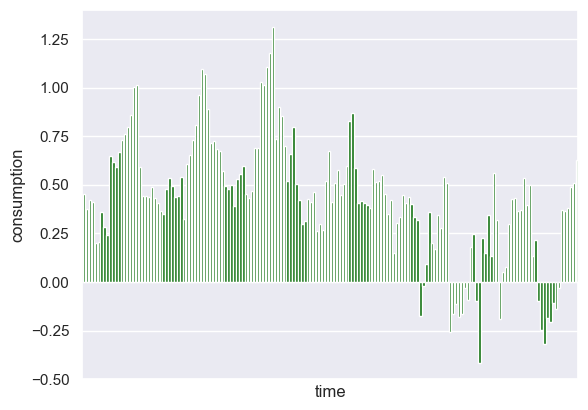

In [63]:
# Graphing the predictions

sns.set()
sns.barplot(x=test_data['time'], y=test_data['consumption'], color='green')

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)  # labels along the bottom edge are off
plt.show()



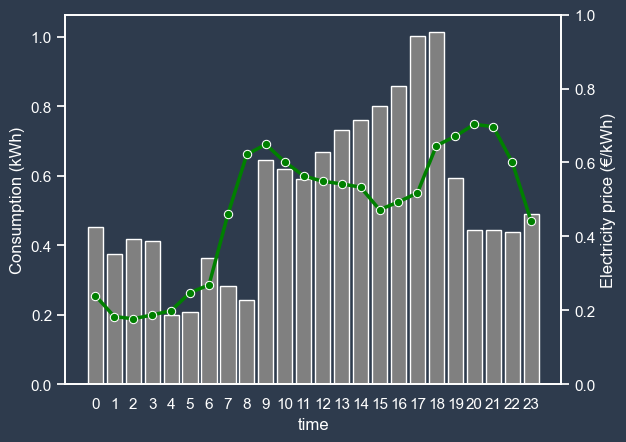

In [64]:
sns.set(rc={'axes.facecolor': '#2e3b4d', 'figure.facecolor': '#2e3b4d',
        'axes.labelcolor': 'white', 'xtick.color': 'white', 'ytick.color': 'white'})

# Graphing 1 day of predictions

# Make a df with predictions for 1 day and electricity price
# Take the first 24 hours
day = test_data[:24]
day = day.reset_index(drop=True)
day['el_price'] = test_data.el_price[:24]
day['time'] = day['time'].apply(lambda x: int(x.split(' ')[1].split(':')[0]))

# Plot the predictions
sns.barplot(x=day['time'], y=day['consumption'], color='gray')
sns.lineplot(x=day['time'], y=day['el_price'], color='green', marker='o', linewidth=2.5)
# First y-axis
plt.ylabel('Consumption (kWh)', color='white')
plt.tick_params(colors='white')
plt.grid(False)
# Second y-axis
ax2 = plt.twinx()
ax2.set_ylabel('Electricity price (€/kWh)', color='white')

# Set ax2 text color
ax2.tick_params(axis='y', colors='white')

ax2.grid(False)

plt.show()
# Show only hours


In [65]:
X.head()

,temp,dwpt,rhum,snow,wspd,wpgt,pres,coco,el_price,valge,...,day_sin,day_cos,hour_sin,hour_cos,month_sin,month_cos,wdir_sin,wdir_cos,wpgt/wspd,avg_temp_of_day
0,11.2,10.3,94.0,0.0,7.2,16.7,12.6,2.0,0.09016,0,...,0.201299,0.97953,0.000000,1.000000,-1.0,-1.836970e-16,-0.642788,0.766044,2.319444,12.6
1,10.7,9.6,93.0,0.0,7.2,13.0,12.6,2.0,0.09251,0,...,0.201299,0.97953,0.258819,0.965926,-1.0,-1.836970e-16,-0.642788,0.766044,1.805556,12.6
2,9.9,9.0,94.0,0.0,7.2,13.0,12.2,2.0,0.08890,0,...,0.201299,0.97953,0.500000,0.866025,-1.0,-1.836970e-16,-0.642788,0.766044,1.805556,12.6
3,10.0,8.4,90.0,0.0,7.2,13.0,11.9,1.0,0.08735,0,...,0.201299,0.97953,0.707107,0.707107,-1.0,-1.836970e-16,-0.500000,0.866025,1.805556,12.6
4,9.0,8.1,94.0,0.0,3.6,13.0,11.4,2.0,0.08688,0,...,0.201299,0.97953,0.866025,0.500000,-1.0,-1.836970e-16,-0.866025,0.500000,3.611111,12.6
